# Homework - 4


https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv was downloaded as the data.csv file in this notebook.

In [245]:
import pandas as pd
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


data=pd.read_csv("data.csv")
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [246]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
data['year']=data['year'].astype(str) 
data=data[['make','model','year','engine_hp','engine_cylinders','transmission_type','vehicle_style','highway_mpg','city_mpg','msrp']]
categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)
for c in categorical_columns:
    data[c] = data[c].str.lower().str.replace(' ', '_')
data.rename(columns={'msrp': 'price'}, inplace=True)
data.fillna(0,inplace=True)
data.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
price                0
dtype: int64

In [247]:
mean_price = data['price'].mean()
from sklearn.model_selection import train_test_split


features = data.drop(columns=['price'], axis=1).copy()
target = (data['price'] > mean_price).astype(int)


df_full_train, X_test, y_full_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(df_full_train,y_full_train, test_size=0.25, random_state=1)

In [248]:
categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)
numerical_columns = data.select_dtypes(include='number').columns.tolist()
numerical_columns.remove('price')

# Question 1: ROC AUC feature importance

In [249]:
from sklearn.metrics import roc_auc_score
import pandas as pd


# Iterate over each numerical variable
for column in numerical_columns:
    # Calculate the AUC score
    auc_score = roc_auc_score(y_train, X_train[column])
    
    # Invert the variable if AUC score is less than 0.5
    if auc_score < 0.5:
        X_train[column] = -X_train[column]
    print(f"{column} : {roc_auc_score(y_train, X_train[column])}")


engine_hp : 0.9171031265539011
engine_cylinders : 0.766116490165669
highway_mpg : 0.6330587871772013
city_mpg : 0.6734244643245233


engine_hp has high roc auc feature importance

# Question 2: Training the model

In [250]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [251]:
val_dict = X_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred),3)

0.983

In [252]:
val_dict = X_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(val_dict)

y_pred = model.predict_proba(X_test)[:, 1]
round(roc_auc_score(y_test, y_pred),3)

0.983

# Question 3: Precision and Recall

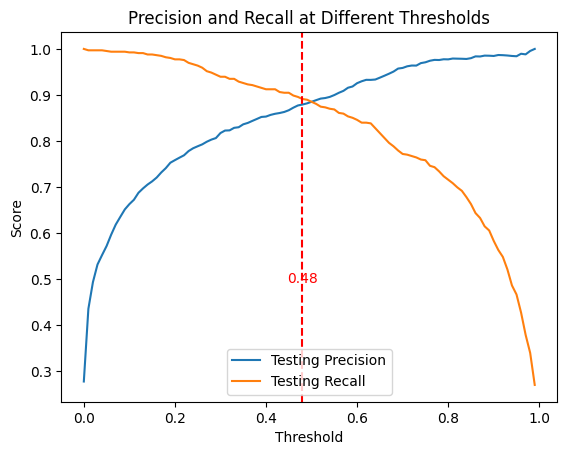

In [253]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
all_precision=[]
all_recall=[]
thresholds=np.arange(0, 1, 0.01)

for t in thresholds:
    precision = precision_score(y_test, y_pred >= t)
    # print('%.2f %.3f' % (t, score))
    recall=recall_score(y_test, y_pred >= t)
    all_precision.append(precision)
    all_recall.append(recall)

# Plot precision and recall
plt.plot(thresholds, all_precision, label='Testing Precision')
plt.plot(thresholds, all_recall, label='Testing Recall')

# Find the intersection point
intersection_threshold =0.48

# Mark the intersection point on the x-axis
plt.axvline(intersection_threshold, color='red', linestyle='--')
plt.text(intersection_threshold, 0.5, f'{intersection_threshold:.2f}', color='red', ha='center', va='center')


# Set plot labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall at Different Thresholds')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Question 4: F1 score


In [254]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
all_f1=[]
thresholds=np.arange(0, 1, 0.01)
max_f1=0
min_threshold=0

for t in thresholds:
    k=f1_score(y_test, y_pred >= t)
    all_f1.append(k)
    if(max_f1<k):
        max_f1=k
        min_threshold=t
    

print(max(all_f1))
print(f"{max_f1} score attained  : {min_threshold}")

0.8863976083707026
0.8863976083707026 score attained  : 0.47000000000000003


# Question 5: 5-Fold CV

In [255]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [256]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train,y_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = y_full_train.iloc[train_idx]
    y_val = y_full_train.iloc[val_idx]

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=1 %.3f +- %.3f' % ( np.mean(scores), np.std(scores)))

5it [01:20, 16.03s/it]

C=1 0.985 +- 0.002


# Question 6: Hyperparemeter Tuning

In [257]:
n_splits = 5
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in tqdm(kfold.split(df_full_train,y_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train.iloc[train_idx]
        y_val = y_full_train.iloc[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

5it [00:32,  6.46s/it]00:00<?, ?it/s]
 25%|██▌       | 1/4 [00:32<01:36, 32.32s/it]

C=0.01 0.952 +- 0.003


5it [01:22, 16.58s/it]
 50%|█████     | 2/4 [01:55<02:04, 62.08s/it]

C=0.1 0.975 +- 0.001


5it [01:28, 17.67s/it]
 75%|███████▌  | 3/4 [03:23<01:14, 74.08s/it]

C=0.5 0.984 +- 0.002


5it [01:32, 18.42s/it]
100%|██████████| 4/4 [04:55<00:00, 73.93s/it]

C=10 0.987 +- 0.002
